In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 184)
(734160, 1)
validation
(101248, 184)
(101248, 1)
test
(100432, 184)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 878593 (3.35 MB)


Trainable params: 878593 (3.35 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:24 - loss: 0.2083 - STD: 1.5640e-04 - MAE: 0.4441

 7/74 [=>............................] - ETA: 0s - loss: 0.0581 - STD: 1.5647e-04 - MAE: 0.1870  

13/74 [====>.........................] - ETA: 0s - loss: 0.0490 - STD: 9.6005e-05 - MAE: 0.1755

19/74 [======>.......................] - ETA: 0s - loss: 0.0392 - STD: 7.1215e-05 - MAE: 0.1470

25/74 [=========>....................] - ETA: 0s - loss: 0.0337 - STD: 5.7514e-05 - MAE: 0.1383

31/74 [===========>..................] - ETA: 0s - loss: 0.0297 - STD: 4.9685e-05 - MAE: 0.1272

37/74 [==============>...............] - ETA: 0s - loss: 0.0271 - STD: 4.4615e-05 - MAE: 0.1165

43/74 [================>.............] - ETA: 0s - loss: 0.0250 - STD: 4.1358e-05 - MAE: 0.1091

49/74 [==================>...........] - ETA: 0s - loss: 0.0235 - STD: 3.9455e-05 - MAE: 0.1056

53/74 [====================>.........] - ETA: 0s - loss: 0.0227 - STD: 3.8589e-05 - MAE: 0.1032

58/74 [======================>.......] - ETA: 0s - loss: 0.0218 - STD: 3.7939e-05 - MAE: 0.1000

64/74 [========================>.....] - ETA: 0s - loss: 0.0209 - STD: 3.7622e-05 - MAE: 0.0968

70/74 [===========================>..] - ETA: 0s - loss: 0.0201 - STD: 3.7799e-05 - MAE: 0.0946

74/74 [==============================] - 3s 25ms/step - loss: 0.0197 - STD: 3.8155e-05 - MAE: 0.0934 - val_loss: 0.0145 - val_STD: 3.8128e-05 - val_MAE: 0.0737


Epoch 2/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0119 - STD: 4.6504e-05 - MAE: 0.0689

 7/74 [=>............................] - ETA: 0s - loss: 0.0118 - STD: 4.8541e-05 - MAE: 0.0674

13/74 [====>.........................] - ETA: 0s - loss: 0.0118 - STD: 5.1966e-05 - MAE: 0.0676

19/74 [======>.......................] - ETA: 0s - loss: 0.0119 - STD: 5.5296e-05 - MAE: 0.0684

25/74 [=========>....................] - ETA: 0s - loss: 0.0118 - STD: 5.9044e-05 - MAE: 0.0685

31/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 6.3077e-05 - MAE: 0.0685

37/74 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 6.7460e-05 - MAE: 0.0686

43/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 7.2355e-05 - MAE: 0.0688

49/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 7.7678e-05 - MAE: 0.0689

55/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 8.3652e-05 - MAE: 0.0690

61/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 9.0294e-05 - MAE: 0.0690

67/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 9.7704e-05 - MAE: 0.0690

73/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.0648e-04 - MAE: 0.0690

74/74 [==============================] - 1s 11ms/step - loss: 0.0120 - STD: 1.0803e-04 - MAE: 0.0690 - val_loss: 0.0145 - val_STD: 1.8743e-04 - val_MAE: 0.0743


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0120 - STD: 2.3013e-04 - MAE: 0.0703

 7/74 [=>............................] - ETA: 0s - loss: 0.0121 - STD: 2.4987e-04 - MAE: 0.0699

13/74 [====>.........................] - ETA: 0s - loss: 0.0121 - STD: 2.7375e-04 - MAE: 0.0696

19/74 [======>.......................] - ETA: 0s - loss: 0.0122 - STD: 3.0158e-04 - MAE: 0.0700

25/74 [=========>....................] - ETA: 0s - loss: 0.0121 - STD: 3.3342e-04 - MAE: 0.0697

31/74 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 3.7150e-04 - MAE: 0.0693

37/74 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 4.1982e-04 - MAE: 0.0694

43/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 4.7872e-04 - MAE: 0.0693

49/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 5.5392e-04 - MAE: 0.0692

55/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 6.5105e-04 - MAE: 0.0691

61/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 7.7969e-04 - MAE: 0.0690

67/74 [==========================>...] - ETA: 0s - loss: 0.0119 - STD: 9.5180e-04 - MAE: 0.0689

73/74 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0688    

74/74 [==============================] - 1s 11ms/step - loss: 0.0118 - STD: 0.0012 - MAE: 0.0687 - val_loss: 0.0136 - val_STD: 0.0042 - val_MAE: 0.0718


Epoch 4/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0110 - STD: 0.0051 - MAE: 0.0669

 7/74 [=>............................] - ETA: 0s - loss: 0.0109 - STD: 0.0062 - MAE: 0.0658

13/74 [====>.........................] - ETA: 0s - loss: 0.0108 - STD: 0.0078 - MAE: 0.0653

19/74 [======>.......................] - ETA: 0s - loss: 0.0105 - STD: 0.0100 - MAE: 0.0646

25/74 [=========>....................] - ETA: 0s - loss: 0.0101 - STD: 0.0129 - MAE: 0.0632

31/74 [===========>..................] - ETA: 0s - loss: 0.0096 - STD: 0.0169 - MAE: 0.0614

37/74 [==============>...............] - ETA: 0s - loss: 0.0090 - STD: 0.0219 - MAE: 0.0593

43/74 [================>.............] - ETA: 0s - loss: 0.0084 - STD: 0.0278 - MAE: 0.0571

49/74 [==================>...........] - ETA: 0s - loss: 0.0079 - STD: 0.0338 - MAE: 0.0551

55/74 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0393 - MAE: 0.0534

61/74 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0442 - MAE: 0.0521

67/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0480 - MAE: 0.0509

73/74 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0514 - MAE: 0.0498

74/74 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0519 - MAE: 0.0497 - val_loss: 0.0040 - val_STD: 0.0722 - val_MAE: 0.0395


Epoch 5/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0885 - MAE: 0.0369

 7/74 [=>............................] - ETA: 0s - loss: 0.0034 - STD: 0.0887 - MAE: 0.0375

13/74 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0891 - MAE: 0.0374

19/74 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0895 - MAE: 0.0372

25/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0899 - MAE: 0.0370

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0903 - MAE: 0.0367

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0905 - MAE: 0.0365

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0910 - MAE: 0.0364

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0913 - MAE: 0.0363

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0362

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0917 - MAE: 0.0361

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0918 - MAE: 0.0359

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0920 - MAE: 0.0358

74/74 [==============================] - 1s 11ms/step - loss: 0.0031 - STD: 0.0921 - MAE: 0.0358 - val_loss: 0.0031 - val_STD: 0.0743 - val_MAE: 0.0360


Epoch 6/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0348

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0934 - MAE: 0.0341

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0342

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0340

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0340

31/74 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0942 - MAE: 0.0339

37/74 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0943 - MAE: 0.0339

43/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0338

49/74 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0947 - MAE: 0.0338

55/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0337

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0949 - MAE: 0.0337

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0337

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0337

74/74 [==============================] - 1s 11ms/step - loss: 0.0027 - STD: 0.0951 - MAE: 0.0337 - val_loss: 0.0029 - val_STD: 0.0786 - val_MAE: 0.0340


Epoch 7/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0026 - STD: 0.0929 - MAE: 0.0330

 7/74 [=>............................] - ETA: 0s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0333

13/74 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0332

19/74 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0330

25/74 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0330

31/74 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0330

37/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0330

43/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0330

49/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0330

55/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0330

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0329

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

74/74 [==============================] - 1s 11ms/step - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329 - val_loss: 0.0031 - val_STD: 0.0807 - val_MAE: 0.0371


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0329

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0326

13/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

19/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

25/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0325

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0325

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0326

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

74/74 [==============================] - 1s 10ms/step - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326 - val_loss: 0.0031 - val_STD: 0.0822 - val_MAE: 0.0370


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0327

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0324

13/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

19/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0327

25/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0325

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0324

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0324

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0324

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0324

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0323

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323 - val_loss: 0.0028 - val_STD: 0.0806 - val_MAE: 0.0351


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0325

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0324

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321 - val_loss: 0.0030 - val_STD: 0.0829 - val_MAE: 0.0367


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0951 - MAE: 0.0318

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0319

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0319

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0319

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0320

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0319

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0319

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0319

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0319

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0319

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

74/74 [==============================] - 1s 10ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320 - val_loss: 0.0031 - val_STD: 0.0835 - val_MAE: 0.0374


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0327

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0320

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0319

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0319

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0984 - MAE: 0.0319

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0320

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0319

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0319

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0319

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319 - val_loss: 0.0028 - val_STD: 0.0816 - val_MAE: 0.0347


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0323

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0320

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0325

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0325

24/74 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0324

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0323

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0320

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0320

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0320

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0320

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0980 - MAE: 0.0320 - val_loss: 0.0028 - val_STD: 0.0824 - val_MAE: 0.0345


Epoch 14/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.0952 - MAE: 0.0319

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0316

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0317

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0317

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317 - val_loss: 0.0030 - val_STD: 0.0840 - val_MAE: 0.0366


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0318

 6/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0321

12/74 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

18/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

24/74 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0319

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0319

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318 - val_loss: 0.0032 - val_STD: 0.0846 - val_MAE: 0.0386


Epoch 16/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0321

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

18/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0316

24/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0316

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318 - val_loss: 0.0028 - val_STD: 0.0824 - val_MAE: 0.0345


Epoch 17/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.0956 - MAE: 0.0317

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0315

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0314

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0315

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315 - val_loss: 0.0028 - val_STD: 0.0825 - val_MAE: 0.0348


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0314

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0313

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0314

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0313

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315 - val_loss: 0.0029 - val_STD: 0.0838 - val_MAE: 0.0358


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0996 - MAE: 0.0316

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0313

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0315

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0318

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0319

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0319

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0319

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0318

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0317

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0317

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316 - val_loss: 0.0029 - val_STD: 0.0835 - val_MAE: 0.0357


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0318

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0318

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0317

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0316

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316 - val_loss: 0.0031 - val_STD: 0.0836 - val_MAE: 0.0370


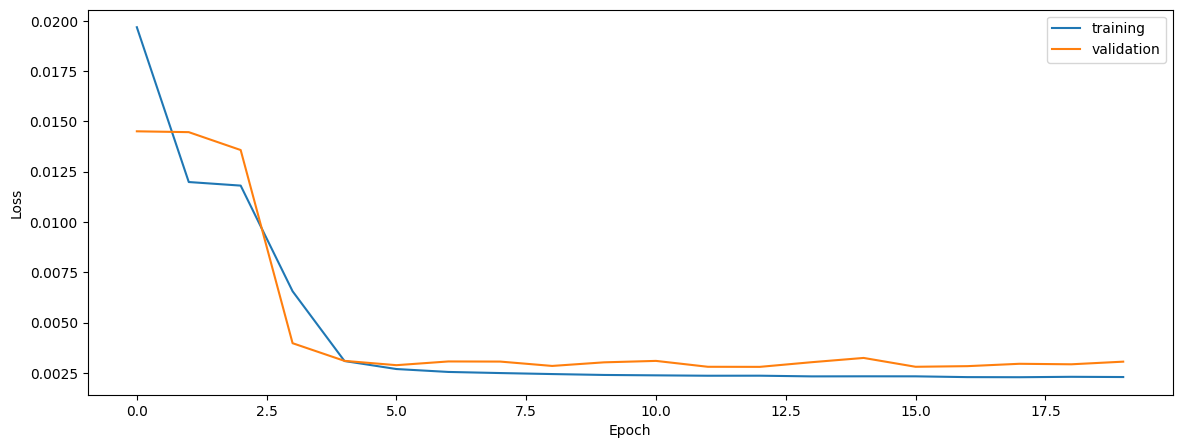

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8982539333540813
0.9023351014409183
0.8993495279689656


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8982539333540813
0.9023351014409183
0.8993495279689656


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9015831959593165
0.9140868354055952
0.9096618868770491


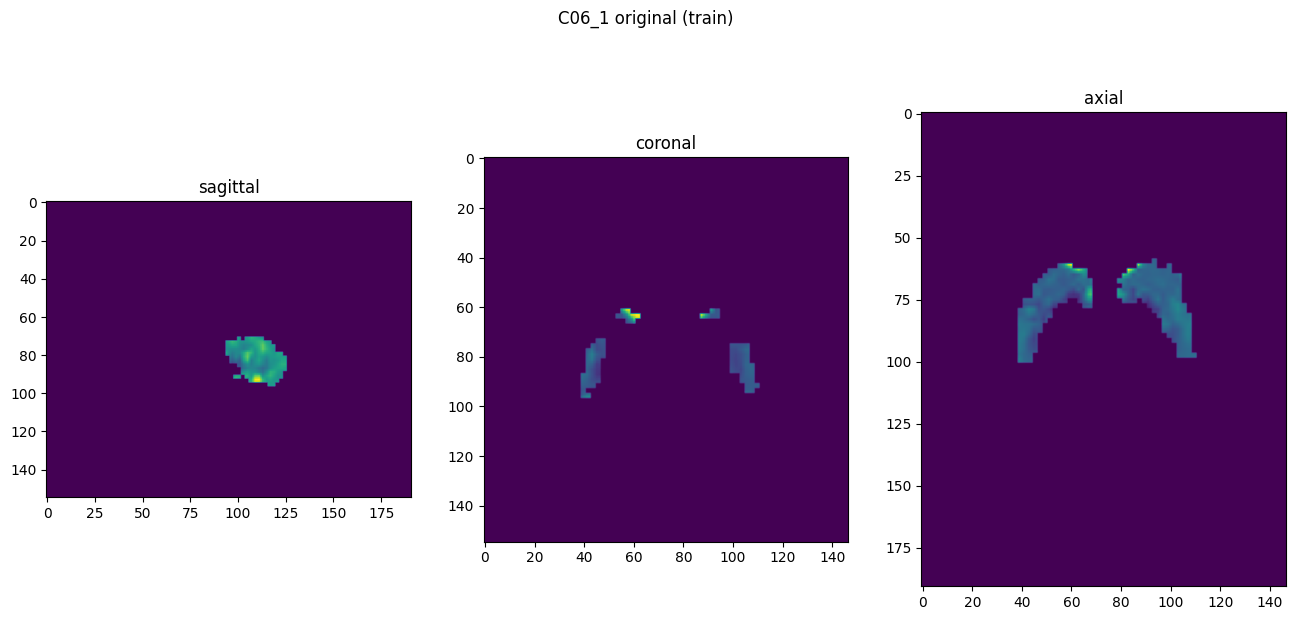

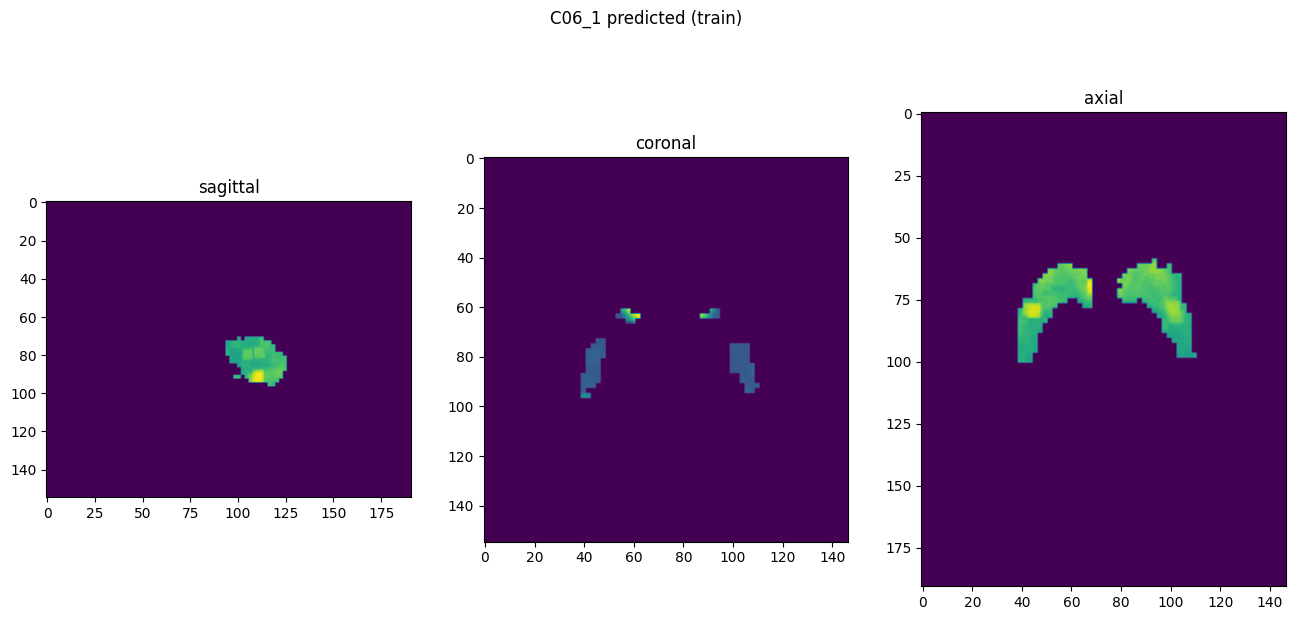

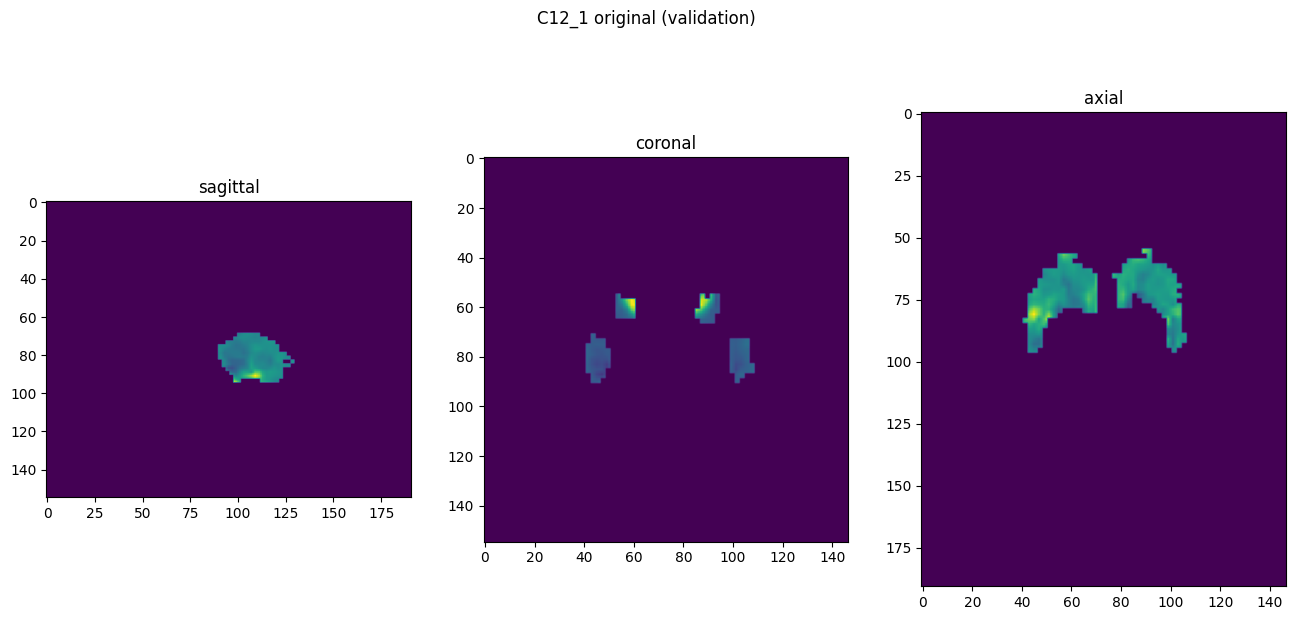

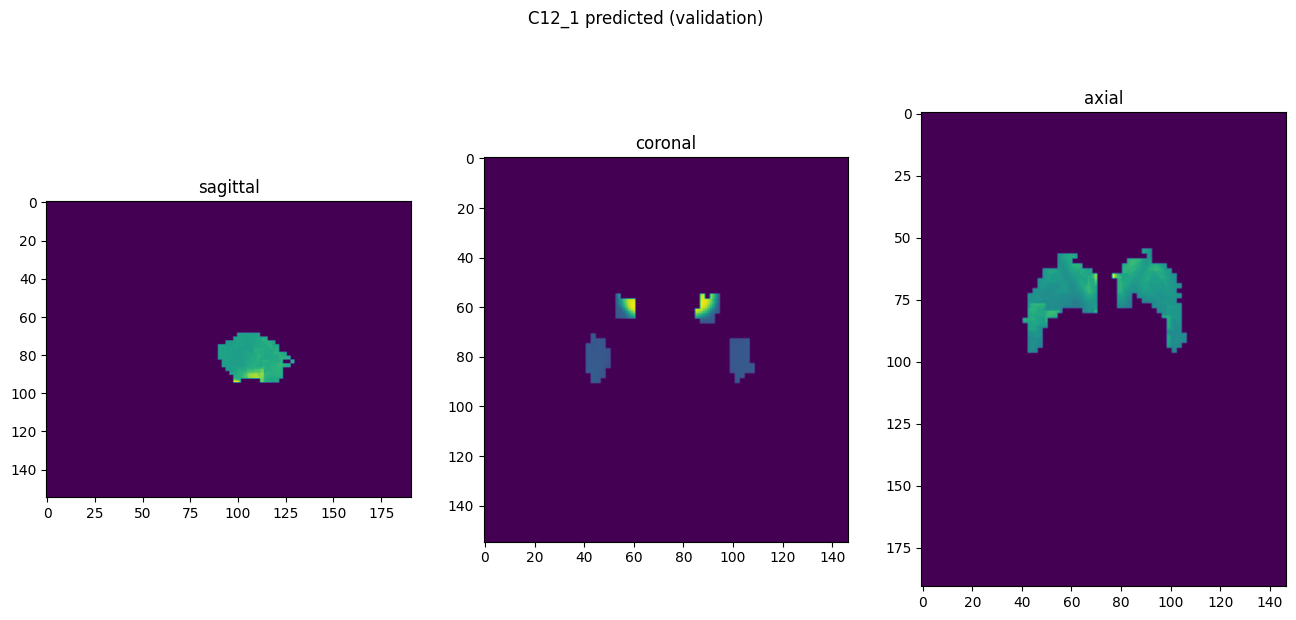

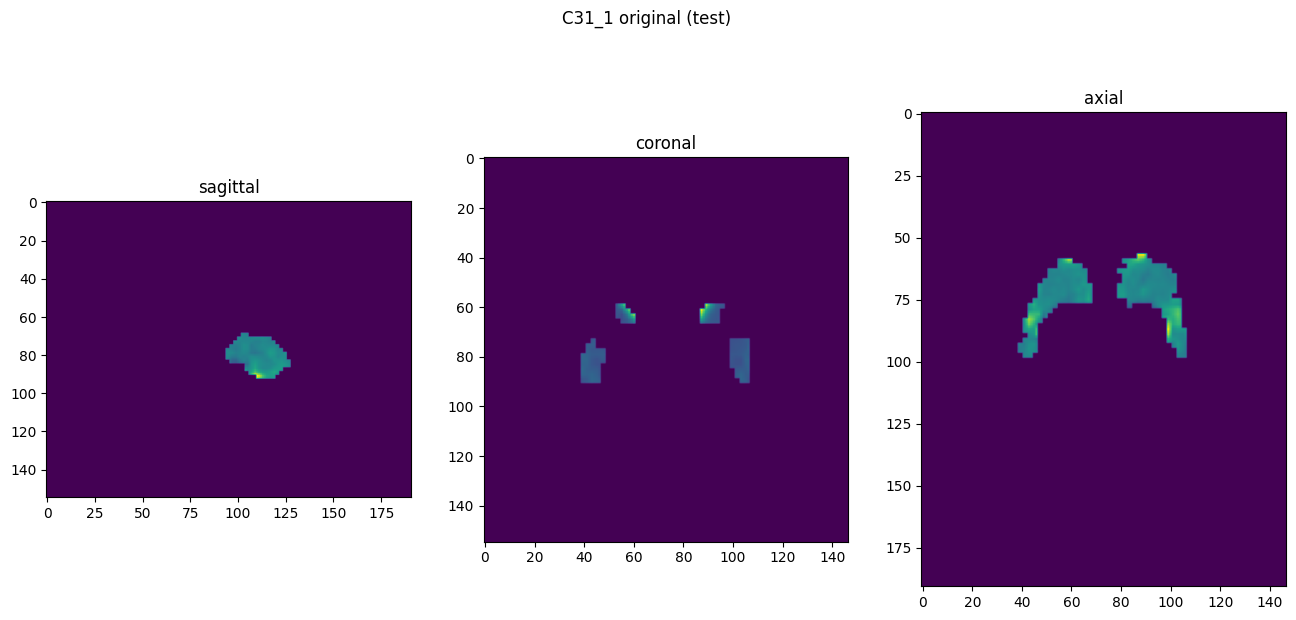

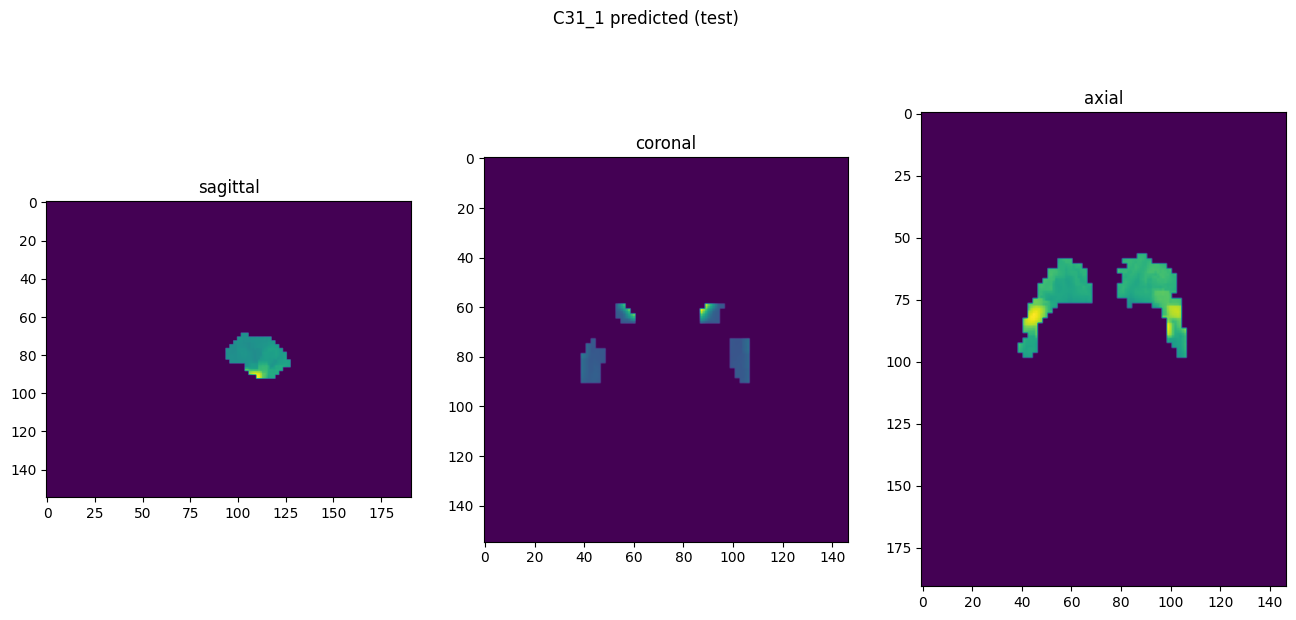

In [10]:
showResults(model, gen, threshold=None, background=False)